# Deep contextualized word representations

# 1.2 本课知识树
<img src="images/WeChat57957b2ba691e058c3b4d0233407d3d7.png"  width="300" height="500" align="left"  />
<img src="images/WeChat43202e35cb12fd7b8932206a48bc32a5.png"  width="400" height="800" align="right" />

# 2 准备工作
## 2.1项目环境配置



* Python3.7
* jupyter notebook
* torch           
* allennlp    
* numpy     




# 2.2 数据集下载
　　 #https://www.clips.uantwerpen.be/conll2003/ner.tgz



# 3 项目代码结构（pycharm中演示）

# 4 算法模块及细节（jupyter和pycharm中演示）

## 任务： elmo做NER

In [1]:
# data utils

In [12]:
import numpy as np
import torch
import os

In [13]:
# shared global variables to be imported from model also
UNK = "$UNK$"
NUM = "$NUM$"
NONE = "O"

# special error message
class MyIOError(Exception):
    def __init__(self, filename):
        # custom error message
        message = """
ERROR: Unable to locate file {}.

FIX: Have you tried running python build_data.py first?
This will build vocab file from your train, test and dev sets and
trimm your word vectors.
""".format(filename)
        super(MyIOError, self).__init__(message)

In [14]:
class CoNLLDataset(object):
    """Class that iterates over CoNLL Dataset

    __iter__ method yields a tuple (words, tags)
        words: list of raw words
        tags: list of raw tags

    If processing_word and processing_tag are not None,
    optional preprocessing is appplied

    Example:
        ```python
        data = CoNLLDataset(filename)
        for sentence, tags in data:
            pass
        ```

    """
    def __init__(self, filename, processing_word=None, processing_tag=None,
                 max_iter=None, use_crf=True):
        """
        Args:
            filename: path to the file
            processing_words: (optional) function that takes a word as input
            processing_tags: (optional) function that takes a tag as input
            max_iter: (optional) max number of sentences to yield

        """
        self.filename = filename
        self.processing_word = processing_word
        self.processing_tag = processing_tag
        self.max_iter = max_iter
        self.use_crf = use_crf
        self.length = None


    def __iter__(self):
        niter = 0
        with open(self.filename) as f:
            words, tags = [], []
            for line in f:
                line = line.strip()
                if (len(line) == 0 or line.startswith("-DOCSTART-")):
                    if len(words) != 0:
                        niter += 1
                        if self.max_iter is not None and niter > self.max_iter:
                            break
                        yield words, tags
                        words, tags = [], []
                else:
                    ls = line.split(' ')
                    word, tag = ls[0],ls[-1]
                    if self.processing_word is not None:
                        word = self.processing_word(word)
                    if self.processing_tag is not None:
                        if self.use_crf:
                            tag = self.processing_tag(tag)
                    words += [word]
                    tags += [tag]


    def __len__(self):
        """Iterates once over the corpus to set and store length"""
        if self.length is None:
            self.length = 0
            for _ in self:
                self.length += 1

        return self.length

In [15]:
def get_vocabs(datasets):
    """Build vocabulary from an iterable of datasets objects

    Args:
        datasets: a list of dataset objects

    Returns:
        a set of all the words in the dataset

    """
    print("Building vocab...")
    vocab_words = set()
    vocab_tags = set()
    for dataset in datasets:
        for words, tags in dataset:
            vocab_words.update(words)
            vocab_tags.update(tags)
    print("- done. {} tokens".format(len(vocab_words)))
    return vocab_words, vocab_tags


def get_char_vocab(dataset):
    """Build char vocabulary from an iterable of datasets objects

    Args:
        dataset: a iterator yielding tuples (sentence, tags)

    Returns:
        a set of all the characters in the dataset

    """
    print("Building char vocab...")
    vocab_char = set()
    for words, _ in dataset:
        for word in words:
            vocab_char.update(word)
    print("- done. {} tokens)")
          
          
def get_glove_vocab(filename):
    """Load vocab from file

    Args:
        filename: path to the glove vectors

    Returns:
        vocab: set() of strings
    """
    print("Building vocab...")
    vocab = set()
    with open(filename, encoding="utf8") as f:
        for line in f:
            word = line.strip().split(' ')[0]
            vocab.add(word)
#     print("- done. {} tokens".format(len(vocab)))
    return vocab
          
          
def write_vocab(vocab, filename):
    """Writes a vocab to a file

    Writes one word per line.

    Args:
        vocab: iterable that yields word
        filename: path to vocab file

    Returns:
        write a word per line

    """
    print("Writing vocab...")
    with open(filename, "w") as f:
        for i, word in enumerate(vocab):
            if i != len(vocab) - 1:
                f.write("{}\n".format(word))
            else:
                f.write(word)
#     print("- done. {} tokens".format(len(vocab)))
 
          
def load_vocab(filename):
    """Loads vocab from a file

    Args:
        filename: (string) the format of the file must be one word per line.

    Returns:
        d: dict[word] = index

    """
    try:
        d = dict()
        with open(filename) as f:
            for idx, word in enumerate(f):
                word = word.strip()
                d[word] = idx

    except IOError:
        raise MyIOError(filename)
    return d
          
          
def export_trimmed_glove_vectors(vocab, glove_filename, trimmed_filename, dim):
    """Saves glove vectors in numpy array

    Args:
        vocab: dictionary vocab[word] = index
        glove_filename: a path to a glove file
        trimmed_filename: a path where to store a matrix in npy
        dim: (int) dimension of embeddings

    """
    embeddings = np.zeros([len(vocab), dim])
    with open(glove_filename, encoding="utf8") as f:
        for line in f:
            line = line.strip().split(' ')
            word = line[0]
            embedding = [float(x) for x in line[1:]]
            if word in vocab:
                word_idx = vocab[word]
                embeddings[word_idx] = np.asarray(embedding)

    np.savez_compressed(trimmed_filename, embeddings=embeddings)
          
          
def get_trimmed_glove_vectors(filename):
    """
    Args:
        filename: path to the npz file

    Returns:
        matrix of embeddings (np array)

    """
    try:
        with np.load(filename) as data:
            return data["embeddings"]

    except IOError:
        raise MyIOError(filename)
          
            
def get_processing_word(vocab_words=None, vocab_chars=None,
                    lowercase=False, chars=False, allow_unk=True):
    """Return lambda function that transform a word (string) into list,
    or tuple of (list, id) of int corresponding to the ids of the word and
    its corresponding characters.

    Args:
        vocab: dict[word] = idx

    Returns:
        f("cat") = ([12, 4, 32], 12345)
                 = (list of char ids, word id)

    """
    def f(word):
        # 0. get chars of words
        if vocab_chars is not None and chars == True:
            char_ids = []
            for char in word:
                # ignore chars out of vocabulary
                if char in vocab_chars:
                    char_ids += [vocab_chars[char]]

        # 1. preprocess word
        if lowercase:
            word = word.lower()
        if word.isdigit():
            word = NUM

        # 2. get id of word
        if vocab_words is not None:
            if word in vocab_words:
                word = vocab_words[word]
            else:
                if allow_unk:
                    word = vocab_words[UNK]
                else:
                    raise Exception("Unknow key is not allowed. Check that "\
                                    "your vocab (tags?) is correct")

        # 3. return tuple char ids, word id
        if vocab_chars is not None and chars == True:
            return char_ids, word
        else:
            return word

    return f
          
          
def _pad_sequences(sequences, pad_tok, max_length):
    """
    Args:
        sequences: a generator of list or tuple
        pad_tok: the char to pad with

    Returns:
        a list of list where each sublist has same length
    """
    sequence_padded, sequence_length = [], []

    for seq in sequences:
        seq = list(seq)
        seq_ = seq[:max_length] + [pad_tok]*max(max_length - len(seq), 0)
        sequence_padded +=  [seq_]
        sequence_length += [min(len(seq), max_length)]

    return sequence_padded, sequence_length
          
          
def pad_sequences(sequences, pad_tok, nlevels=1):
    """
    Args:
        sequences: a generator of list or tuple
        pad_tok: the char to pad with
        nlevels: "depth" of padding, for the case where we have characters ids

    Returns:
        a list of list where each sublist has same length

    """
    if nlevels == 1:
        max_length = max(map(lambda x : len(x), sequences))
        sequence_padded, sequence_length = _pad_sequences(sequences,
                                            pad_tok, max_length)

    elif nlevels == 2:
        max_length_word = max([max(map(lambda x: len(x), seq))
                               for seq in sequences])
        sequence_padded, sequence_length = [], []
        for seq in sequences:
            # all words are same length now
            sp, sl = _pad_sequences(seq, pad_tok, max_length_word)
            sequence_padded += [sp]
            sequence_length += [sl]

        max_length_sentence = max(map(lambda x : len(x), sequences))
        sequence_padded, _ = _pad_sequences(sequence_padded,
                [pad_tok]*max_length_word, max_length_sentence)
        sequence_length, _ = _pad_sequences(sequence_length, 0,
                max_length_sentence)

    return sequence_padded, sequence_length


def minibatches(data, minibatch_size, use_crf=True):
    """
    Args:
        data: generator of (sentence, tags) tuples
        minibatch_size: (int)

    Yields:
        list of tuples

    """
    x_batch, y_batch = [], []
    for (x, y) in data:
        if len(x_batch) == minibatch_size:
            yield x_batch, y_batch
            x_batch, y_batch = [], []

        if type(x[0]) == tuple:
            x = zip(*x)
        x_batch += [x]
        if use_crf:
            y_batch += [y]
        else:
            if any([x.isdigit() for x in y]):
                y_batch.append([int(x) for x in y if x.isdigit()])
            else:
                y_batch.append([0,0,0,0,0])

    if len(x_batch) != 0:
        yield x_batch, y_batch


def get_chunk_type(tok, idx_to_tag):
    """
    Args:
        tok: id of token, ex 4
        idx_to_tag: dictionary {4: "B-PER", ...}

    Returns:
        tuple: "B", "PER"

    """
    if isinstance(tok, torch.Tensor): tok = tok.item()
    tag_name = idx_to_tag[tok]

    tag_class = tag_name.split('-')[0]
    tag_type = tag_name.split('-')[-1]
    return tag_class, tag_type


def get_chunks(seq, tags):
    """Given a sequence of tags, group entities and their position

    Args:
        seq: [4, 4, 0, 0, ...] sequence of labels
        tags: dict["O"] = 4

    Returns:
        list of (chunk_type, chunk_start, chunk_end)

    Example:
        seq = [4, 5, 0, 3]
        tags = {"B-PER": 4, "I-PER": 5, "B-LOC": 3}
        result = [("PER", 0, 2), ("LOC", 3, 4)]

    """
    default = tags[NONE]
    idx_to_tag = {idx: tag for tag, idx in tags.items()}
    chunks = []
    chunk_type, chunk_start = None, None
    for i, tok in enumerate(seq):
        # End of a chunk 1
        if tok == default and chunk_type is not None:
            # Add a chunk.
            chunk = (chunk_type, chunk_start, i)
            chunks.append(chunk)
            chunk_type, chunk_start = None, None

        # End of a chunk + start of a chunk!
        elif tok != default:
            tok_chunk_class, tok_chunk_type = get_chunk_type(tok, idx_to_tag)
            if chunk_type is None:
                chunk_type, chunk_start = tok_chunk_type, i
            elif tok_chunk_type != chunk_type or tok_chunk_class == "B":
                chunk = (chunk_type, chunk_start, i)
                chunks.append(chunk)
                chunk_type, chunk_start = tok_chunk_type, i
        else:
            pass

    # end condition
    if chunk_type is not None:
        chunk = (chunk_type, chunk_start, len(seq))
        chunks.append(chunk)

    return chunks


# ============general_utils=========

In [16]:
import time
import sys
import logging
import numpy as np

In [17]:
def get_logger(filename):
    """Return a logger instance that writes in filename

    Args:
        filename: (string) path to log.txt

    Returns:
        logger: (instance of logger)

    """
    logger = logging.getLogger('logger')
    logger.setLevel(logging.DEBUG)
    logging.basicConfig(format='%(message)s', level=logging.DEBUG)
    handler = logging.FileHandler(filename)
    handler.setLevel(logging.DEBUG)
    handler.setFormatter(logging.Formatter(
            '%(asctime)s:%(levelname)s: %(message)s'))
    logging.getLogger().addHandler(handler)

    return logger

In [18]:
class Progbar(object):
    """Progbar class copied from keras (https://github.com/fchollet/keras/)

    Displays a progress bar.
    Small edit : added strict arg to update
    # Arguments
        target: Total number of steps expected.
        interval: Minimum visual progress update interval (in seconds).
    """

    def __init__(self, target, width=30, verbose=1):
        self.width = width
        self.target = target
        self.sum_values = {}
        self.unique_values = []
        self.start = time.time()
        self.total_width = 0
        self.seen_so_far = 0
        self.verbose = verbose

    def update(self, current, values=[], exact=[], strict=[]):
        """
        Updates the progress bar.
        # Arguments
            current: Index of current step.
            values: List of tuples (name, value_for_last_step).
                The progress bar will display averages for these values.
            exact: List of tuples (name, value_for_last_step).
                The progress bar will display these values directly.
        """

        for k, v in values:
            if k not in self.sum_values:
                self.sum_values[k] = [v * (current - self.seen_so_far),
                                      current - self.seen_so_far]
                self.unique_values.append(k)
            else:
                self.sum_values[k][0] += v * (current - self.seen_so_far)
                self.sum_values[k][1] += (current - self.seen_so_far)
        for k, v in exact:
            if k not in self.sum_values:
                self.unique_values.append(k)
            self.sum_values[k] = [v, 1]

        for k, v in strict:
            if k not in self.sum_values:
                self.unique_values.append(k)
            self.sum_values[k] = v

        self.seen_so_far = current

        now = time.time()
        if self.verbose == 1:
            prev_total_width = self.total_width
            sys.stdout.write("\b" * prev_total_width)
            sys.stdout.write("\r")

            numdigits = int(np.floor(np.log10(self.target))) + 1
            barstr = '%%%dd/%%%dd [' % (numdigits, numdigits)
            bar = barstr % (current, self.target)
            prog = float(current)/self.target
            prog_width = int(self.width*prog)
            if prog_width > 0:
                bar += ('='*(prog_width-1))
                if current < self.target:
                    bar += '>'
                else:
                    bar += '='
            bar += ('.'*(self.width-prog_width))
            bar += ']'
            sys.stdout.write(bar)
            self.total_width = len(bar)

            if current:
                time_per_unit = (now - self.start) / current
            else:
                time_per_unit = 0
            eta = time_per_unit*(self.target - current)
            info = ''
            if current < self.target:
                info += ' - ETA: %ds' % eta
            else:
                info += ' - %ds' % (now - self.start)
            for k in self.unique_values:
                if type(self.sum_values[k]) is list:
                    info += ' - %s: %.4f' % (k,
                        self.sum_values[k][0] / max(1, self.sum_values[k][1]))
                else:
                    info += ' - %s: %s' % (k, self.sum_values[k])

            self.total_width += len(info)
            if prev_total_width > self.total_width:
                info += ((prev_total_width-self.total_width) * " ")

            sys.stdout.write(info)
            sys.stdout.flush()

            if current >= self.target:
                sys.stdout.write("\n")

        if self.verbose == 2:
            if current >= self.target:
                info = '%ds' % (now - self.start)
                for k in self.unique_values:
                    info += ' - %s: %.4f' % (k,
                        self.sum_values[k][0] / max(1, self.sum_values[k][1]))
                sys.stdout.write(info + "\n")

    def add(self, n, values=[]):
        self.update(self.seen_so_far+n, values)


# ============config=========

In [19]:
class Config():
    def __init__(self, load=True):
        """Initialize hyperparameters and load vocabs

        Args:
            load_embeddings: (bool) if True, load embeddings into
                np array, else None

        """
        # directory for training outputs
        if not os.path.exists(self.dir_output):
            os.makedirs(self.dir_output)

        # create instance of logger
        self.logger = get_logger(self.path_log)

        # load if requested (default)
        if load:
            self.load()

    def load(self):
        """Loads vocabulary, processing functions and embeddings

        Supposes that build_data.py has been run successfully and that
        the corresponding files have been created (vocab and trimmed GloVe
        vectors)

        """
        # 1. vocabulary
        self.vocab_words = load_vocab(self.filename_words)
        self.vocab_tags  = load_vocab(self.filename_tags)
        self.vocab_chars = load_vocab(self.filename_chars)

        self.nwords     = len(self.vocab_words)
        self.nchars     = len(self.vocab_chars)
        self.ntags      = len(self.vocab_tags)

        # 2. get processing functions that map str -> id
        self.processing_word = get_processing_word(self.vocab_words,
                self.vocab_chars, lowercase=True, chars=self.use_chars)
        self.processing_tag  = get_processing_word(self.vocab_tags,
                lowercase=False, allow_unk=False)

        # 3. get pre-trained embeddings
        self.embeddings = (get_trimmed_glove_vectors(self.filename_trimmed)
                if self.use_pretrained else None)


    # general config
    dir_output = "results/test/"
    dir_model  = dir_output
    path_log   = dir_output + "log.txt"

    # embeddings
    dim_word = 300
    dim_char = 100

    # glove files
    filename_glove = "data/glove.6B.{}d.txt".format(dim_word)
    # trimmed embeddings (created from glove_filename with build_data.py)
    filename_trimmed = "data/glove.6B.{}d.trimmed.npz".format(dim_word)
    use_pretrained = True

    # dataset
    # filename_dev = "data/coNLL/eng/eng.testa.iob"
    # filename_test = "data/coNLL/eng/eng.testb.iob"
    # filename_train = "data/coNLL/eng/eng.train.iob"

    #filename_dev = filename_test = filename_train = "data/test.txt" # test

    filename_dev = "data/dev.txt"
    filename_test = "data/test.txt"
    filename_train = "data/train.txt"

    max_iter = None # if not None, max number of examples in Dataset

    # vocab (created from dataset with build_data.py)
    filename_words = "data/words.txt"
    filename_tags = "data/tags.txt"
    filename_chars = "data/chars.txt"

    # training
    train_embeddings = False
    nepochs          = 15
    dropout          = 0.5
    batch_size       = 5
    lr_method        = "adam"
    lr               = 0.001
    lr_decay         = 0.9
    epoch_drop       = 1 # Step Decay: per # epochs to apply lr_decay
    clip             = -1 # if negative, no clipping
    nepoch_no_imprv  = 3

    # model hyperparameters
    hidden_size_char = 100 # lstm on chars
    hidden_size_lstm = 300 # lstm on word embeddings

    ner_model_path = "saves/ner_{}e_glove".format(nepochs)

    # elmo config
    use_elmo = True
    dim_elmo = 1024

    # NOTE: if both chars and crf, only 1.6x slower on GPU
    use_crf = True # if crf, training is 1.7x slower on CPU
    use_chars = False if use_elmo else True#  if char embedding, training is 3.5x slower on CPU


# ===========core============

In [20]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import os
import spacy

USE_GPU = torch.cuda.is_available()

In [21]:
def to_gpu(x, *args, **kwargs):
    '''puts pytorch variable to gpu, if cuda is available and USE_GPU is set to true. '''
    return x.cuda(*args, **kwargs) if USE_GPU else x

def children(m): return m if isinstance(m, (list, tuple)) else list(m.children())

def set_trainable_attr(m,b):
    m.trainable=b
    for p in m.parameters(): p.requires_grad=b

def apply_leaf(m, f):
    c = children(m)
    if isinstance(m, nn.Module): f(m)
    if len(c)>0:
        for l in c: apply_leaf(l,f)

def set_trainable(l, b):
    apply_leaf(l, lambda m: set_trainable_attr(m,b))

def save_model(m, p): torch.save(m.state_dict(), p)

def T(a, half=False, cuda=True):
    """
    Convert numpy array into a pytorch tensor.
    if Cuda is available and USE_GPU=True, store resulting tensor in GPU.
    """
    if not torch.is_tensor(a):
        a = np.array(np.ascontiguousarray(a))
        if a.dtype in (np.int8, np.int16, np.int32, np.int64):
            a = torch.LongTensor(a.astype(np.int64))
        elif a.dtype in (np.float32, np.float64):
            a = torch.cuda.HalfTensor(a) if half else torch.FloatTensor(a)
        else: raise NotImplementedError(a.dtype)
    if cuda: a = to_gpu(a)
    return a

def load_ner_model(m, p, strict=True):
    sd = torch.load(p, map_location=lambda storage, loc: storage)
    names = set(m.state_dict().keys())
    for n in list(sd.keys()): # list "detatches" the iterator
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    m.load_state_dict(sd, strict=strict)

# =========ner_model======

In [22]:
class NERModel(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.use_elmo = config.use_elmo

        if not self.use_elmo:
            self.emb = nn.Embedding(self.config.nwords, self.config.dim_word, padding_idx=0)
            self.char_embeddings = nn.Embedding(self.config.nchars, self.config.dim_char, padding_idx=0)
            self.char_lstm = nn.LSTM(self.config.dim_char, self.config.hidden_size_char, bidirectional=True)

        self.dropout = nn.Dropout(p=self.config.dropout)
        self.word_lstm = nn.LSTM(self.config.dim_elmo if self.use_elmo else self.config.dim_word+2*self.config.hidden_size_char,
                                 self.config.hidden_size_lstm, bidirectional=True)#dim_elmo=1024,hidden_size_lstm=300

        self.linear = LinearClassifier(self.config, layers=[self.config.hidden_size_lstm*2, self.config.ntags], drops=[0.5])#hidden_size_lstm=300,ntags=9


    def forward(self, input):
        # Word_dim = (batch_size x sent_length)
        # char_dim = (batch_size x sent_length x word_length)

        if self.use_elmo:
            word_emb = self.dropout(input.transpose(0,1))
            #[31,5,1024]

        else:
            word_input, char_input = input[0], input[1]
            word_input.transpose_(0,1)

            # Word Embedding
            word_emb = self.emb(word_input) #shape= S*B*wnh

            # Char LSTM
            char_emb = self.char_embeddings(char_input.view(-1, char_input.size(2))) #https://stackoverflow.com/questions/47205762/embedding-3d-data-in-pytorch
            char_emb = char_emb.view(*char_input.size(), -1) #dim = BxSxWxE

            _, (h, c) = self.char_lstm(char_emb.view(-1, char_emb.size(2), char_emb.size(3)).transpose(0,1)) #(num_layers * num_directions, batch, hidden_size) = 2*BS*cnh
            char_output = torch.cat((h[0], h[1]), 1) #shape = BS*2cnh
            char_output = char_output.view(char_emb.size(0), char_emb.size(1), -1).transpose(0,1) #shape = S*B*2cnh

            # Concat char output and word output
            word_emb = torch.cat((word_emb, char_output), 2) #shape = S*B*(wnh+2cnh)
            word_emb = self.dropout(word_emb)

        output, (h, c) = self.word_lstm(word_emb) #shape = S*B*hidden_size_lstm=[31,5,600]
        output = self.dropout(output)

        output = self.linear(output)#[31,5,9]
        return output #shape = S*B*ntags

In [23]:
class LinearBlock(nn.Module):
    def __init__(self, ni, nf, drop):
        super().__init__()
        self.lin = nn.Linear(ni, nf)
        self.drop = nn.Dropout(drop)
        self.bn = nn.BatchNorm1d(ni)

    def forward(self, x):
        return self.lin(self.drop(self.bn(x)))

In [24]:
class LinearClassifier(nn.Module):
    def __init__(self, config, layers, drops):
        self.config = config
        super().__init__()
        self.layers = nn.ModuleList([
            LinearBlock(layers[i], layers[i + 1], drops[i]) for i in range(len(layers) - 1)])
        #[600,9]
        
    def forward(self, input):
        output = input
        sl,bs,_ = output.size()
        x = output.view(-1, 2*self.config.hidden_size_lstm)#[155,600]

        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return l_x.view(sl, bs, self.config.ntags)

# ===============crf==============

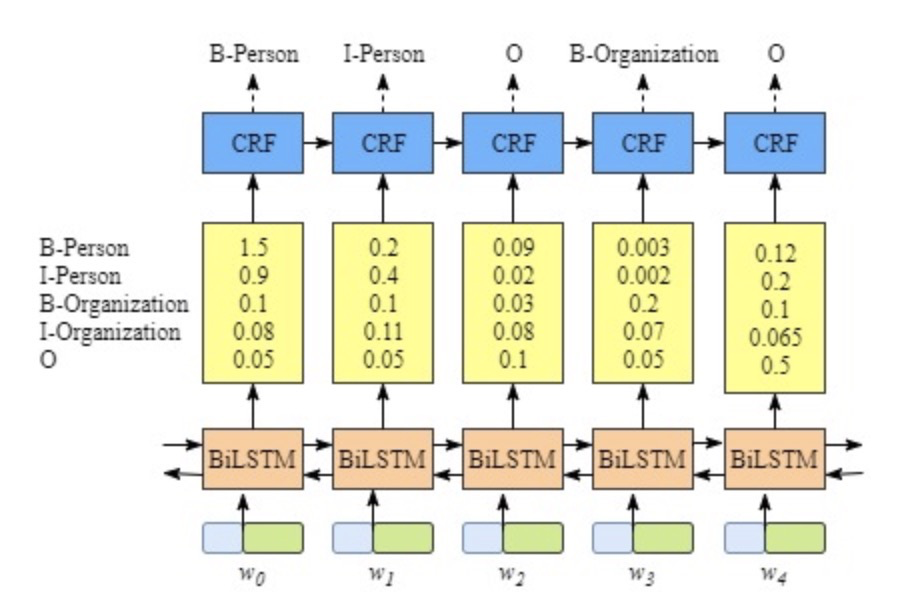

真实转移矩阵

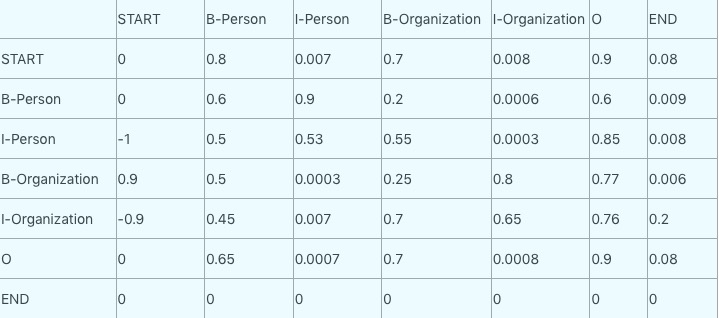

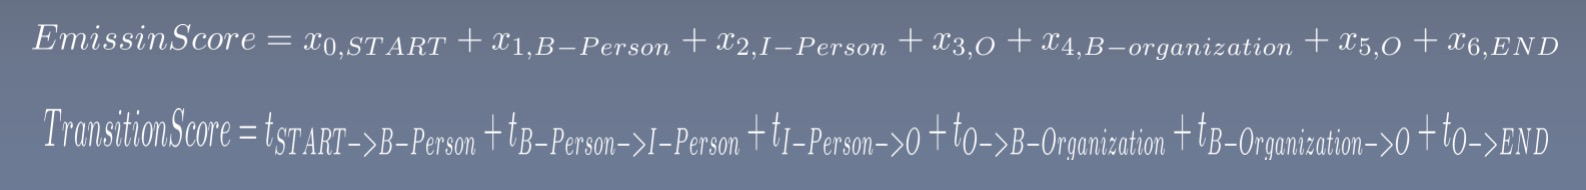

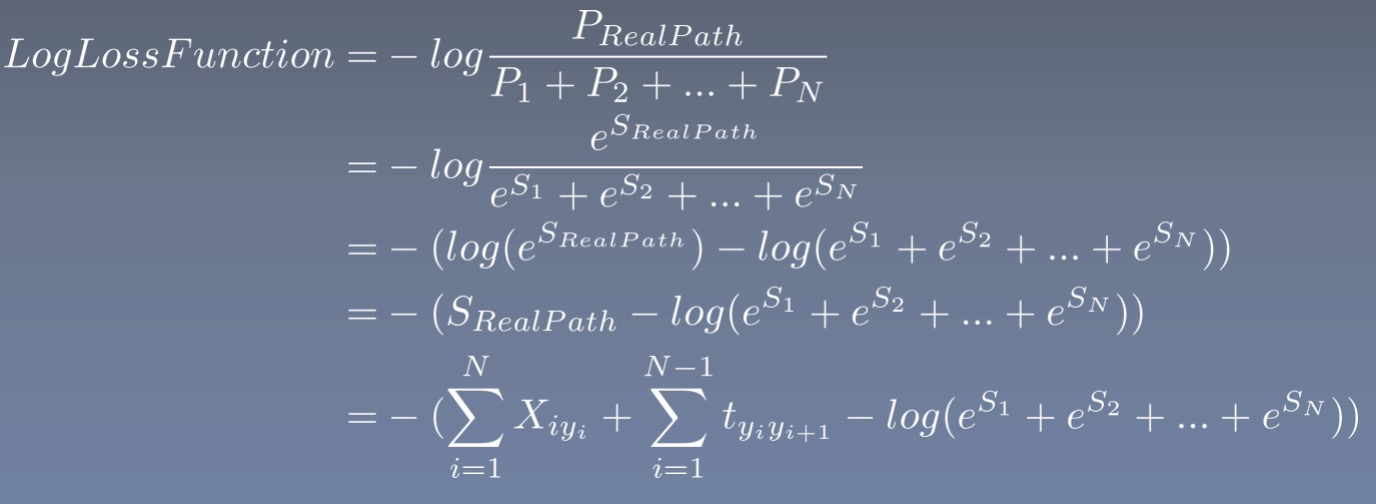

发射矩阵

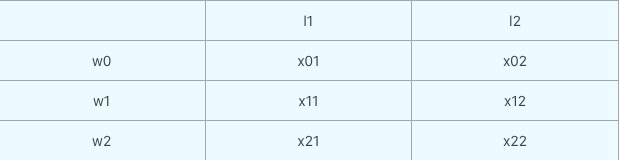

转移矩阵

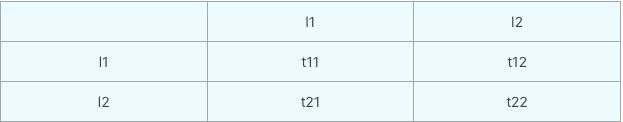

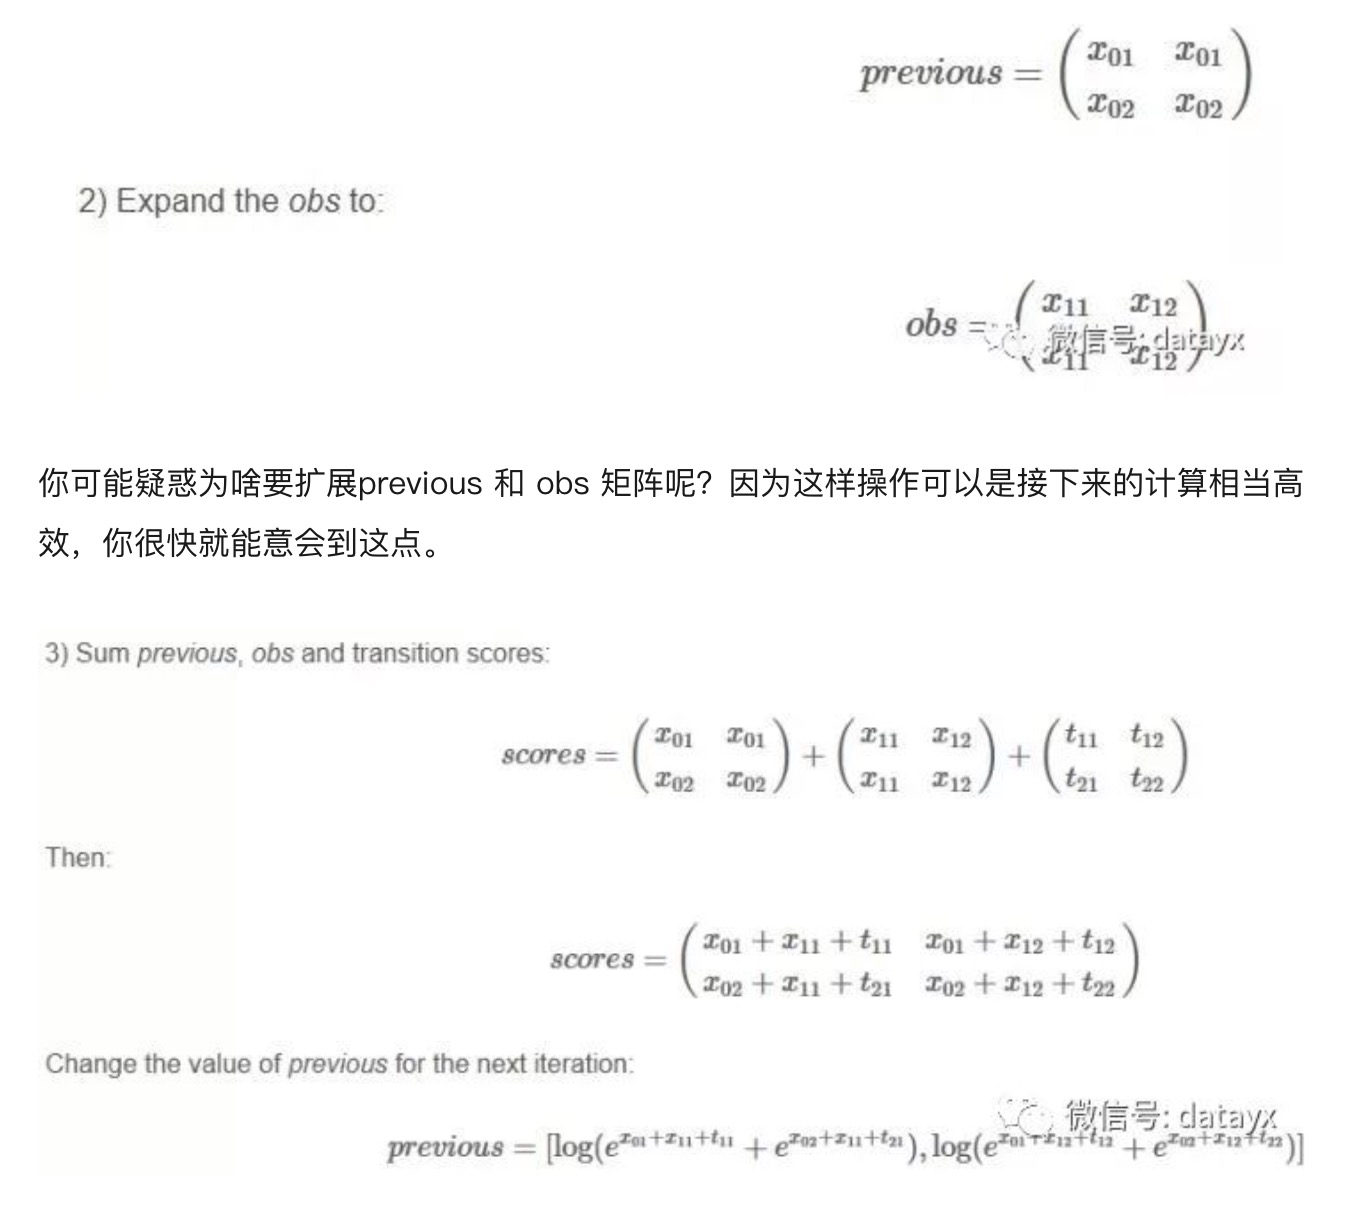

In [25]:
from typing import List, Optional, Union

from torch.autograd import Variable
import torch
import torch.nn as nn

In [26]:
class CRF(nn.Module):
    """Conditional random field.
    This module implements a conditional random field [LMP]. The forward computation
    of this class computes the log likelihood of the given sequence of tags and
    emission score tensor. This class also has ``decode`` method which finds the
    best tag sequence given an emission score tensor using `Viterbi algorithm`_.
    Arguments
    ---------
    num_tags : int
        Number of tags.
    Attributes
    ----------
    num_tags : int
        Number of tags passed to ``__init__``.
    start_transitions : :class:`~torch.nn.Parameter`
        Start transition score tensor of size ``(num_tags,)``.
    end_transitions : :class:`~torch.nn.Parameter`
        End transition score tensor of size ``(num_tags,)``.
    transitions : :class:`~torch.nn.Parameter`
        Transition score tensor of size ``(num_tags, num_tags)``.
    References
    ----------
    .. [LMP] Lafferty, J., McCallum, A., Pereira, F. (2001).
             "Conditional random fields: Probabilistic models for segmenting and
             labeling sequence data". *Proc. 18th International Conf. on Machine
             Learning*. Morgan Kaufmann. pp. 282–289.
    .. _Viterbi algorithm: https://en.wikipedia.org/wiki/Viterbi_algorithm
    """
    def __init__(self, num_tags: int) -> None:
        if num_tags <= 0:
            raise ValueError(f'invalid number of tags: {num_tags}')
        super().__init__()
        self.num_tags = num_tags
        self.start_transitions = nn.Parameter(torch.Tensor(num_tags))
        self.end_transitions = nn.Parameter(torch.Tensor(num_tags))
        self.transitions = nn.Parameter(torch.Tensor(num_tags, num_tags))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Initialize the transition parameters.
        The parameters will be initialized randomly from a uniform distribution
        between -0.1 and 0.1.
        """
        nn.init.uniform(self.start_transitions, -0.1, 0.1)
        nn.init.uniform(self.end_transitions, -0.1, 0.1)
        nn.init.uniform(self.transitions, -0.1, 0.1)

    def __repr__(self) -> str:
        return f'{self.__class__.__name__}(num_tags={self.num_tags})'

    def forward(self,
                emissions: Variable,
                tags: Variable,
                mask: Optional[Variable] = None,
                reduce: bool = True,
                ) -> Variable:
        """Compute the log likelihood of the given sequence of tags and emission score.
        Arguments
        ---------
        emissions : :class:`~torch.autograd.Variable`
            Emission score tensor of size ``(seq_length, batch_size, num_tags)``.
        tags : :class:`~torch.autograd.Variable`
            Sequence of tags as ``LongTensor`` of size ``(seq_length, batch_size)``.
        mask : :class:`~torch.autograd.Variable`, optional
            Mask tensor as ``ByteTensor`` of size ``(seq_length, batch_size)``.
        reduce : bool
            Whether to sum the log likelihood over the batch.
        Returns
        -------
        :class:`~torch.autograd.Variable`
            The log likelihood. This will have size (1,) if ``reduce=True``, ``(batch_size,)``
            otherwise.
        """
        if emissions.dim() != 3:
            raise ValueError(f'emissions must have dimension of 3, got {emissions.dim()}')
        if tags.dim() != 2:
            raise ValueError(f'tags must have dimension of 2, got {tags.dim()}')
        if emissions.size()[:2] != tags.size():
            raise ValueError(
                'the first two dimensions of emissions and tags must match, '
                f'got {tuple(emissions.size()[:2])} and {tuple(tags.size())}'
            )
        if emissions.size(2) != self.num_tags:
            raise ValueError(
                f'expected last dimension of emissions is {self.num_tags}, '
                f'got {emissions.size(2)}'
            )
        if mask is not None:
            if tags.size() != mask.size():
                raise ValueError(
                    f'size of tags and mask must match, got {tuple(tags.size())} '
                    f'and {tuple(mask.size())}'
                )
            if not all(mask[0].data):
                raise ValueError('mask of the first timestep must all be on')

        if mask is None:
            mask = Variable(self._new(tags.size()).fill_(1)).byte()
        
        #计算前面部分
        numerator = self._compute_joint_llh(emissions, tags, mask)
        #计算后面部分
        denominator = self._compute_log_partition_function(emissions, mask)
        llh = numerator - denominator
        return llh if not reduce else torch.sum(llh)

    def decode(self,
               emissions: Union[Variable, torch.FloatTensor],
               mask: Optional[Union[Variable, torch.ByteTensor]] = None) -> List[List[int]]:
        """Find the most likely tag sequence using Viterbi algorithm.
        Arguments
        ---------
        emissions : :class:`~torch.autograd.Variable` or :class:`~torch.FloatTensor`
            Emission score tensor of size ``(seq_length, batch_size, num_tags)``.
        mask : :class:`~torch.autograd.Variable` or :class:`torch.ByteTensor`
            Mask tensor of size ``(seq_length, batch_size)``.
        Returns
        -------
        list
            List of list containing the best tag sequence for each batch.
        """
        if emissions.dim() != 3:
            raise ValueError(f'emissions must have dimension of 3, got {emissions.dim()}')
        if emissions.size(2) != self.num_tags:
            raise ValueError(
                f'expected last dimension of emissions is {self.num_tags}, '
                f'got {emissions.size(2)}'
            )
        if mask is not None and emissions.size()[:2] != mask.size():
            raise ValueError(
                'the first two dimensions of emissions and mask must match, '
                f'got {tuple(emissions.size()[:2])} and {tuple(mask.size())}'
            )

        if isinstance(emissions, Variable):
            emissions = emissions.data
        if mask is None:
            mask = self._new(emissions.size()[:2]).fill_(1).byte()
        elif isinstance(mask, Variable):
            mask = mask.data

        return self._viterbi_decode(emissions, mask)

    def _compute_joint_llh(self,
                           emissions: Variable,
                           tags: Variable,
                           mask: Variable) -> Variable:
        # emissions: (seq_length, batch_size, num_tags)
        # tags: (seq_length, batch_size)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and tags.dim() == 2
        assert emissions.size()[:2] == tags.size()
        assert emissions.size(2) == self.num_tags
        assert mask.size() == tags.size()
        assert all(mask[0].data)

        seq_length = emissions.size(0)
        mask = mask.float()#[31,5]

        # Start transition score
        llh = self.start_transitions[tags[0]]  # (batch_size,)=5
        #emissions 发射矩阵==每个词对应的tag的概率==[31,5,9]
        for i in range(seq_length - 1):
            cur_tag, next_tag = tags[i], tags[i+1]#[5],[5]
            # Emission score for current tag
            # X(i,yi)
            llh += emissions[i].gather(1, cur_tag.view(-1, 1)).squeeze(1) * mask[i]#取出当前词的emissions[5,9]对应的tag[5,1]==[5]
            # Transition score to next tag
            #T(y-[y+1])
            transition_score = self.transitions[cur_tag, next_tag]#转移矩阵从当前的tag传递到下个tag [5]
            # Only add transition score if the next tag is not masked (mask == 1)
            llh += transition_score * mask[i+1]

        # Find last tag index
        last_tag_indices = mask.long().sum(0) - 1  # (batch_size,)
        last_tags = tags.gather(0, last_tag_indices.view(1, -1)).squeeze(0)

        # End transition score
        llh += self.end_transitions[last_tags]
        # Emission score for the last tag, if mask is valid (mask == 1)
        llh += emissions[-1].gather(1, last_tags.view(-1, 1)).squeeze(1) * mask[-1]

        return llh

    def _compute_log_partition_function(self,
                                        emissions: Variable,
                                        mask: Variable) -> Variable:
        # emissions: (seq_length, batch_size, num_tags)
        # mask: (seq_length, batch_size)
        assert emissions.dim() == 3 and mask.dim() == 2
        assert emissions.size()[:2] == mask.size()
        assert emissions.size(2) == self.num_tags
        assert all(mask[0].data)

        seq_length = emissions.size(0)
        mask = mask.float()

        # Start transition score and first emission
        log_prob = self.start_transitions.view(1, -1) + emissions[0]#[5,9]
        # Here, log_prob has size (batch_size, num_tags) where for each batch,
        # the j-th column stores the log probability that the current timestep has tag j

        for i in range(1, seq_length):
            # Broadcast log_prob over all possible next tags
            broadcast_log_prob = log_prob.unsqueeze(2)  # (batch_size, num_tags, 1)
            # Broadcast transition score over all instances in the batch
            broadcast_transitions = self.transitions.unsqueeze(0)  # (1, num_tags, num_tags)
            # Broadcast emission score over all possible current tags
            broadcast_emissions = emissions[i].unsqueeze(1)  # (batch_size, 1, num_tags)
            # Sum current log probability, transition, and emission scores
            score = broadcast_log_prob + broadcast_transitions \
                + broadcast_emissions  # (batch_size, num_tags, num_tags)
            # Sum over all possible current tags, but we're in log prob space, so a sum
            # becomes a log-sum-exp
            score = self._log_sum_exp(score, 1)  # (batch_size, num_tags)
            # Set log_prob to the score if this timestep is valid (mask == 1), otherwise
            # leave it alone
            log_prob = score * mask[i].unsqueeze(1) + log_prob * (1.-mask[i]).unsqueeze(1)

        # End transition score
        log_prob += self.end_transitions.view(1, -1)
        # Sum (log-sum-exp) over all possible tags
        return self._log_sum_exp(log_prob, 1)  # (batch_size,)

    def _viterbi_decode(self, emissions: torch.FloatTensor, mask: torch.ByteTensor) \
            -> List[List[int]]:
        # Get input sizes
        seq_length = emissions.size(0)
        batch_size = emissions.size(1)
        sequence_lengths = mask.long().sum(dim=0)

        # emissions: (seq_length, batch_size, num_tags)
        assert emissions.size(2) == self.num_tags

        # list to store the decoded paths
        best_tags_list = []

        # Start transition
        viterbi_score = []
        viterbi_score.append(self.start_transitions.data + emissions[0])
        viterbi_path = []

        # Here, viterbi_score is a list of tensors of shapes of (num_tags,) where value at
        # index i stores the score of the best tag sequence so far that ends with tag i
        # viterbi_path saves where the best tags candidate transitioned from; this is used
        # when we trace back the best tag sequence

        # Viterbi algorithm recursive case: we compute the score of the best tag sequence
        # for every possible next tag
        for i in range(1, seq_length):
            # Broadcast viterbi score for every possible next tag
            broadcast_score = viterbi_score[i - 1].view(batch_size, -1, 1)
            # Broadcast emission score for every possible current tag
            broadcast_emission = emissions[i].view(batch_size, 1, -1)
            # Compute the score matrix of shape (batch_size, num_tags, num_tags) where
            # for each sample, each entry at row i and column j stores the score of
            # transitioning from tag i to tag j and emitting
            score = broadcast_score + self.transitions.data + broadcast_emission
            # Find the maximum score over all possible current tag
            best_score, best_path = score.max(1)  # (batch_size,num_tags,)
            # Save the score and the path
            viterbi_score.append(best_score)
            viterbi_path.append(best_path)

        # Now, compute the best path for each sample
        for idx in range(batch_size):
            # Find the tag which maximizes the score at the last timestep; this is our best tag
            # for the last timestep
            seq_end = sequence_lengths[idx]-1
            _, best_last_tag = (viterbi_score[seq_end][idx] + self.end_transitions.data).max(0)
            best_tags = [best_last_tag.item()] #[best_last_tag[0]] #[best_last_tag.item()]

            # We trace back where the best last tag comes from, append that to our best tag
            # sequence, and trace it back again, and so on
            for path in reversed(viterbi_path[:sequence_lengths[idx] - 1]):
                best_last_tag = path[idx][best_tags[-1]]
                best_tags.append(best_last_tag)

            # Reverse the order because we start from the last timestep
            best_tags.reverse()
            best_tags_list.append(best_tags)
        return best_tags_list

    @staticmethod
    def _log_sum_exp(tensor: Variable, dim: int) -> Variable:
        # Find the max value along `dim`
        offset, _ = tensor.max(dim)
        # Make offset broadcastable
        broadcast_offset = offset.unsqueeze(dim)
        # Perform log-sum-exp safely
        safe_log_sum_exp = torch.log(torch.sum(torch.exp(tensor - broadcast_offset), dim))
        # Add offset back
        return offset + safe_log_sum_exp

    def _new(self, *args, **kwargs) -> torch.FloatTensor:
        param = next(self.parameters())
        return param.data.new(*args, **kwargs)


# ============ner_learner==========

In [27]:
from torch.optim.lr_scheduler import StepLR

if os.name == "posix": from allennlp.modules.elmo import Elmo, batch_to_ids

I0708 23:21:53.970380 4649145792 file_utils.py:39] PyTorch version 1.5.1 available.


In [28]:
""" Works with pytorch 0.4.0 """
class NERLearner(object):
    """
    NERLearner class that encapsulates a pytorch nn.Module model and ModelData class
    Contains methods for training a testing the model
    """
    def __init__(self, config, model):
        super().__init__()
        self.config = config
        self.logger = self.config.logger
        self.model = model
        self.model_path = config.dir_model
        self.use_elmo = config.use_elmo


        self.idx_to_tag = {idx: tag for tag, idx in
                           self.config.vocab_tags.items()}

        self.criterion = CRF(self.config.ntags)
        self.optimizer = optim.Adam(self.model.parameters())

        if self.use_elmo:
            options_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_options.json"
            weight_file = "https://s3-us-west-2.amazonaws.com/allennlp/models/elmo/2x4096_512_2048cnn_2xhighway/elmo_2x4096_512_2048cnn_2xhighway_weights.hdf5"
            self.elmo = Elmo(options_file, weight_file, 2, dropout=0)
        else:
            self.load_emb()

        if USE_GPU:
            self.use_cuda = True
            self.logger.info("GPU found.")
            self.model = model.cuda()
            self.criterion = self.criterion.cuda()
            if self.use_elmo:
                self.elmo = self.elmo.cuda()
                print("Moved elmo to cuda")
        else:
            self.model = model.cpu()
            self.use_cuda = False
            self.logger.info("No GPU found.")

    def get_model_path(self, name):
        return os.path.join(self.model_path,name)+'.h5'

    def get_layer_groups(self, do_fc=False):
        return children(self.model)

    def freeze_to(self, n):
        c=self.get_layer_groups()
        for l in c:
            set_trainable(l, False)
        for l in c[n:]:
            set_trainable(l, True)

    def unfreeze(self):
        self.freeze_to(0)

    def save(self, name=None):
        if not name:
            name = self.config.ner_model_path
        save_model(self.model, self.get_model_path(name))
        self.logger.info(f"Saved model at {self.get_model_path(name)}")

    def load_emb(self):
        self.model.emb.weight = nn.Parameter(T(self.config.embeddings))
        self.model.emb.weight.requires_grad = False
        self.logger.info('Loading pretrained word embeddings')

    def load(self, fn=None):
        if not fn: fn = self.config.ner_model_path
        fn = self.get_model_path(fn)
        load_ner_model(self.model, fn, strict=True)
        self.logger.info(f"Loaded model from {fn}")

    def batch_iter(self, train, batch_size, return_lengths=False, shuffle=False, sorter=False):
        """
        Builds a generator from the given dataloader to be fed into the model

        Args:
            train: DataLoader
            batch_size: size of each batch
            return_lengths: if True, generator returns a list of sequence lengths for each
                            sample in the batch
                            ie. sequence_lengths = [8,7,4,3]
            shuffle: if True, shuffles the data for each epoch
            sorter: if True, uses a sorter to shuffle the data

        Returns:
            nbatches: (int) number of batches
            data_generator: batch generator yielding
                                dict inputs:{'word_ids' : np.array([[padded word_ids in sent1], ...])
                                             'char_ids': np.array([[[padded char_ids in word1_sent1], ...],
                                                                    [padded char_ids in word1_sent2], ...],
                                                                    ...])}
                                labels: np.array([[padded label_ids in sent1], ...])
                                sequence_lengths: list([len(sent1), len(sent2), ...])

        """
        nbatches = (len(train) + batch_size - 1) // batch_size

        def data_generator():
            while True:
                if shuffle: train.shuffle()
                elif sorter==True and train.sorter: train.sort()

                for i, (words, labels) in enumerate(minibatches(train, batch_size)):

                    # perform padding of the given data
                    if self.config.use_chars:
                        char_ids, word_ids = zip(*words)
                        word_ids, sequence_lengths = pad_sequences(word_ids, 1)
                        char_ids, word_lengths = pad_sequences(char_ids, pad_tok=0,
                        nlevels=2)

                    else:
                        word_ids, sequence_lengths = pad_sequences(words, 0)

                    if self.use_elmo:
                        word_ids = words

                    if labels:
                        labels, _ = pad_sequences(labels, 0)
                        # if categorical
                        ## labels = [to_categorical(label, num_classes=len(train.tag_itos)) for label in labels]

                    # build dictionary
                    inputs = {
                        "word_ids": np.asarray(word_ids)
                    }

                    if self.config.use_chars:
                        inputs["char_ids"] = np.asarray(char_ids)

                    if return_lengths:
                        yield(inputs, np.asarray(labels), sequence_lengths)

                    else:
                        yield (inputs, np.asarray(labels))

        return (nbatches, data_generator())


    def fine_tune(self, train, dev=None):
        """
        Fine tune the NER model by freezing the pre-trained encoder and training the newly
        instantiated layers for 1 epochs
        """
        self.logger.info("Fine Tuning Model")
        self.fit(train, dev, epochs=1, fine_tune=True)


    def fit(self, train, dev=None, epochs=None, fine_tune=False):
        """
        Fits the model to the training dataset and evaluates on the validation set.
        Saves the model to disk
        """
        if not epochs:
            epochs = self.config.nepochs
        batch_size = self.config.batch_size

        nbatches_train, train_generator = self.batch_iter(train, batch_size,
                                                          return_lengths=True)
        if dev:
            nbatches_dev, dev_generator = self.batch_iter(dev, batch_size,
                                                      return_lengths=True)

        scheduler = StepLR(self.optimizer, step_size=1, gamma=self.config.lr_decay)

        if not fine_tune: self.logger.info("Training Model")

        f1s = []

        for epoch in range(epochs):
            scheduler.step()
            self.train(epoch, nbatches_train, train_generator, fine_tune=fine_tune)

            if dev:
                f1 = self.test(nbatches_dev, dev_generator, fine_tune=fine_tune)

            # Early stopping
            if len(f1s) > 0:
                if f1 < max(f1s[max(-self.config.nepoch_no_imprv, -len(f1s)):]): #if sum([f1 > f1s[max(-i, -len(f1s))] for i in range(1,self.config.nepoch_no_imprv+1)]) == 0:
                    print("No improvement in the last 3 epochs. Stopping training")
                    break
            else:
                f1s.append(f1)

        if fine_tune:
            self.save(self.config.ner_ft_path)
        else :
            self.save(self.config.ner_model_path)


    def train(self, epoch, nbatches_train, train_generator, fine_tune=False):
        self.logger.info('\nEpoch: %d' % epoch)
        self.model.train()
        if not self.use_elmo: self.model.emb.weight.requires_grad = False

        train_loss = 0
        correct = 0
        total = 0
        total_step = None

        prog = Progbar(target=nbatches_train)

        for batch_idx, (inputs, targets, sequence_lengths) in enumerate(train_generator):

            if batch_idx == nbatches_train: break
            if inputs['word_ids'].shape[0] == 1:
                self.logger.info('Skipping batch of size=1')
                continue

            total_step = batch_idx
            targets = T(targets, cuda=self.use_cuda).transpose(0,1).contiguous()
            self.optimizer.zero_grad()

            if self.use_elmo:
                sentences = inputs['word_ids']#list(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
                character_ids = batch_to_ids(sentences)
                if self.use_cuda:
                    character_ids = character_ids.cuda()
                embeddings = self.elmo(character_ids)
                word_input = embeddings['elmo_representations'][0]#[5,31,1024]
                word_input, targets = Variable(word_input, requires_grad=False), \
                                      Variable(targets)#[31,5]
                inputs = (word_input)

            else:
                word_input = T(inputs['word_ids'], cuda=self.use_cuda)
                char_input = T(inputs['char_ids'], cuda=self.use_cuda)
                word_input, char_input, targets = Variable(word_input, requires_grad=False), \
                                                  Variable(char_input, requires_grad=False),\
                                                  Variable(targets)
                inputs = (word_input, char_input)


            outputs = self.model(inputs)

            # Create mask
            if self.use_elmo:
                mask = Variable(embeddings['mask'].transpose(0,1))
                if self.use_cuda:
                    mask = mask.cuda()
            else:
                mask = create_mask(sequence_lengths, targets, cuda=self.use_cuda)

            # Get CRF Loss
            loss = -1*self.criterion(outputs, targets, mask=mask)
            loss.backward()
            self.optimizer.step()

            # Callbacks
            train_loss += loss.item()
            predictions = self.criterion.decode(outputs, mask=mask)
            masked_targets = mask_targets(targets, sequence_lengths)

            t_ = mask.type(torch.LongTensor).sum().item()
            total += t_
            c_ = sum([1 if p[i] == mt[i] else 0 for p, mt in zip(predictions, masked_targets) for i in range(len(p))])
            correct += c_

            prog.update(batch_idx + 1, values=[("train loss", loss.item())], exact=[("Accuracy", 100*c_/t_)])

        self.logger.info("Train Loss: %.3f, Train Accuracy: %.3f%% (%d/%d)" %(train_loss/(total_step+1), 100.*correct/total, correct, total) )


    def test(self, nbatches_val, val_generator, fine_tune=False):
        self.model.eval()
        accs = []
        test_loss = 0
        correct_preds = 0
        total_correct = 0
        total_preds = 0
        total_step = None

        for batch_idx, (inputs, targets, sequence_lengths) in enumerate(val_generator):
            if batch_idx == nbatches_val: break
            if inputs['word_ids'].shape[0] == 1:
                self.logger.info('Skipping batch of size=1')
                continue

            total_step = batch_idx
            targets = T(targets, cuda=self.use_cuda).transpose(0,1).contiguous()

            if self.use_elmo:
                sentences = inputs['word_ids']#list(['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
                character_ids = batch_to_ids(sentences)
                if self.use_cuda:
                    character_ids = character_ids.cuda()
                embeddings = self.elmo(character_ids)
                word_input = embeddings['elmo_representations'][1]
                word_input, targets = Variable(word_input, requires_grad=False), \
                                      Variable(targets)
                inputs = (word_input)

            else:
                word_input = T(inputs['word_ids'], cuda=self.use_cuda)
                char_input = T(inputs['char_ids'], cuda=self.use_cuda)
                word_input, char_input, targets = Variable(word_input, requires_grad=False), \
                                                  Variable(char_input, requires_grad=False),\
                                                  Variable(targets)
                inputs = (word_input, char_input)

            outputs = self.model(inputs)

            # Create mask
            if self.use_elmo:
                mask = Variable(embeddings['mask'].transpose(0,1))
                if self.use_cuda:
                    mask = mask.cuda()
            else:
                mask = create_mask(sequence_lengths, targets, cuda=self.use_cuda)

            # Get CRF Loss
            loss = -1*self.criterion(outputs, targets, mask=mask)

            # Callbacks
            test_loss += loss.item()
            predictions = self.criterion.decode(outputs, mask=mask)
            masked_targets = mask_targets(targets, sequence_lengths)

            for lab, lab_pred in zip(masked_targets, predictions):

                accs    += [1 if a==b else 0 for (a, b) in zip(lab, lab_pred)]

                lab_chunks      = set(get_chunks(lab, self.config.vocab_tags))
                lab_pred_chunks = set(get_chunks(lab_pred,
                                                 self.config.vocab_tags))

                correct_preds += len(lab_chunks & lab_pred_chunks)
                total_preds   += len(lab_pred_chunks)
                total_correct += len(lab_chunks)

        p   = correct_preds / total_preds if correct_preds > 0 else 0
        r   = correct_preds / total_correct if correct_preds > 0 else 0
        f1  = 2 * p * r / (p + r) if correct_preds > 0 else 0
        acc = np.mean(accs)

        self.logger.info("Val Loss : %.3f, Val Accuracy: %.3f%%, Val F1: %.3f%%" %(test_loss/(total_step+1), 100*acc, 100*f1))
        return 100*f1

    def evaluate(self,test):
        batch_size = self.config.batch_size
        nbatches_test, test_generator = self.batch_iter(test, batch_size,
                                                        return_lengths=True)
        self.logger.info('Evaluating on test set')
        self.test(nbatches_test, test_generator)

    def predict_batch(self, words):
        self.model.eval()
        if len(words) == 1:
            mult = np.ones(2).reshape(2, 1).astype(int)

        if self.use_elmo:
            sentences = words
            character_ids = batch_to_ids(sentences)
            if self.use_cuda:
                character_ids = character_ids.cuda()
            embeddings = self.elmo(character_ids)
            word_input = embeddings['elmo_representations'][1]
            word_input = Variable(word_input, requires_grad=False)

            if len(words) == 1:
                word_input = ((mult*word_input.transpose(0,1)).transpose(0,1).contiguous()).type(torch.FloatTensor)

            word_input = T(word_input, cuda=self.use_cuda)
            inputs = (word_input)

        else:
            #char_ids, word_ids = zip(*words)
            char_ids = [[c[0] for c in s] for s in words]
            word_ids = [[x[1] for x in s] for s in words]
            word_ids, sequence_lengths = pad_sequences(word_ids, 1)
            char_ids, word_lengths = pad_sequences(char_ids, pad_tok=0,
                                                   nlevels=2)
            word_ids = np.asarray(word_ids)
            char_ids = np.asarray(char_ids)

            if len(words) == 1:
                word_ids = mult*word_ids
                char_ids = (mult*char_ids.transpose(1,0,2)).transpose(1,0,2)
            word_input = T(word_ids, cuda=self.use_cuda)
            char_input = T(char_ids, cuda=self.use_cuda)

            word_input, char_input = Variable(word_input, requires_grad=False), \
                                     Variable(char_input, requires_grad=False)

            inputs = (word_input, char_input)


        outputs = self.model(inputs)

        predictions = self.criterion.decode(outputs)

        predictions = [p[:i] for p, i in zip(predictions, sequence_lengths)]

        return predictions

    def predict(self, sentences):
        """Returns list of tags

        Args:
            words_raw: list of words (string), just one sentence (no batch)

        Returns:
            preds: list of tags (string), one for each word in the sentence

        """
        nlp = spacy.load('en')
        doc = nlp(sentences)
        words_raw = [[token.text for token in sent] for sent in doc.sents]
        if self.use_elmo:
            words = words_raw
        else:
            words = [[self.config.processing_word(w) for w in s] for s in words_raw]
            # print(words)
            # raise NameError('testing')
            # if type(words[0]) == tuple:
            #     words = zip(*words)

        pred_ids = self.predict_batch(words)
        preds = [[self.idx_to_tag[idx.item() if isinstance(idx, torch.Tensor) else idx]  for idx in s] for s in pred_ids]

        return preds


def create_mask(sequence_lengths, targets, cuda, batch_first=False):
    """ Creates binary mask """
    mask = Variable(torch.ones(targets.size()).type(torch.ByteTensor))
    if cuda: mask = mask.cuda()

    for i,l in enumerate(sequence_lengths):
        if batch_first:
            if l < targets.size(1):
                mask.data[i, l:] = 0
        else:
            if l < targets.size(0):
                mask.data[l:, i] = 0

    return mask


def mask_targets(targets, sequence_lengths, batch_first=False):
    """ Masks the targets """
    if not batch_first:
         targets = targets.transpose(0,1)
    t = []
    for l, p in zip(targets,sequence_lengths):
        t.append(l[:p].data.tolist())
    return t


# =============build_data=========

In [29]:
def build():
    """Procedure to build data

    You MUST RUN this procedure. It iterates over the whole dataset (train,
    dev and test) and extract the vocabularies in terms of words, tags, and
    characters. Having built the vocabularies it writes them in a file. The
    writing of vocabulary in a file assigns an id (the line #) to each word.
    It then extract the relevant GloVe vectors and stores them in a np array
    such that the i-th entry corresponds to the i-th word in the vocabulary.


    Args:
        config: (instance of Config) has attributes like hyper-params...

    """
    # 1. get config and processing of words
    config = Config(load=False)

    #2. Get processing word generator
    processing_word = get_processing_word(lowercase=True)

    # 3. Generators
    dev   = CoNLLDataset(config.filename_dev, processing_word)
    test  = CoNLLDataset(config.filename_test, processing_word)
    train = CoNLLDataset(config.filename_train, processing_word)


    # 4. Build Word and Tag vocab
    vocab_words, vocab_tags = get_vocabs([train, dev, test])
    vocab_glove = get_glove_vocab(config.filename_glove)

    # 5. Get a vocab set for words in both vocab_words and vocab_glove
    vocab = vocab_words & vocab_glove
    vocab.add(UNK)
    vocab.add(NUM)

    # 6. Save vocab
    write_vocab(vocab, config.filename_words)
    write_vocab(vocab_tags, config.filename_tags)

    # 7. Trim GloVe Vectors
    vocab = load_vocab(config.filename_words)
    export_trimmed_glove_vectors(vocab, config.filename_glove,
                                config.filename_trimmed, config.dim_word)

    # Build and save char vocab
    train = CoNLLDataset(config.filename_train)
    vocab_chars = get_char_vocab(train)
    write_vocab(vocab_chars, config.filename_chars)
    
    
build()

Building vocab...


FileNotFoundError: [Errno 2] No such file or directory: 'data/train.txt'

# ===============train===========

In [ ]:
def main():
    # create instance of config
    config = Config()
    if config.use_elmo: config.processing_word = None

    #build model
    model = NERModel(config)

    # create datasets
    dev = CoNLLDataset(config.filename_dev, config.processing_word,
                         config.processing_tag, config.max_iter, config.use_crf)
    train = CoNLLDataset(config.filename_train, config.processing_word,
                         config.processing_tag, config.max_iter, config.use_crf)

    learn = NERLearner(config, model)
    learn.fit(train, dev)
    
main()

<div id="disqus_thread"></div>
<script>
    /**
     *  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
     *  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
     */
    /*
    var disqus_config = function () {
        this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
        this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
    };
    */
    (function() {  // REQUIRED CONFIGURATION VARIABLE: EDIT THE SHORTNAME BELOW
        var d = document, s = d.createElement('script');
        
        s.src = 'https://EXAMPLE.disqus.com/embed.js';  // IMPORTANT: Replace EXAMPLE with your forum shortname!
        
        s.setAttribute('data-timestamp', +new Date());
        (d.head || d.body).appendChild(s);
    })();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript" rel="nofollow">comments powered by Disqus.</a></noscript>